# Watchlist and (MOC) Area hits
### Ken Smith
This code gets a previously defined area on the sky with [MOC](https://cds-astro.github.io/mocpy/) (multi-order coverage maps), an [IVOA standard](https://ivoa.net/documents/MOC/) and grabs the ZTF objects that lie within that area that are also in a watchlist.  The code is in development, but for more information on converting (e.g.) Healpix maps of GW events to MOCs, feel free to get in touch.

We have defined the SDSS footprint within Lasair as https://lasair-ztf.lsst.ac.uk/area/2/ (area number 2).  The area number is needed for the SQL query later on.  Likewise, we also have a predefined watchlist of BLLacs https://lasair-ztf.lsst.ac.uk/watchlist/35/ (number 35).  In the current implementation, the watchlist number is also required later.

Demonstrates usage of:
* Area Hits
* Watchlist Hits
* /query/
* /objects/

This code demonstrates a query that can check a watchlist for ZTF hits that also overlap a previously defined area of the sky - e.g. GW 90% contour or SDSS area.  See https://lasair-ztf.lsst.ac.uk/area/ and https://lasair-ztf.lsst.ac.uk/watchlist/.

### Python (3 only) requirements - pip install
lasair, requests

In [24]:
import sys
sys.path.append('../../../lasair/lasair_api')
#!pip install lasair

### Grab my Lasair API token
Get your Lasair token before you start. You can log into [Lasair](https://lasair.lsst.ac.uk) and click "My Profile"
at top right. Or use the command-line below.
```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
Make a file called settings.py with a line like: `API_TOKEN = '0123456789abcdefxxxxxxxxxxxxxxxxxxxxxxxx'`

In [25]:
import settings
from astropy.time import Time
import matplotlib.pyplot as plt
from lasair import LasairError, lasair_client as lasair

### Make an SQL query
We are going to make an SQL query that includes a watchlist and a watchmap. 
Find the ones you like on the Lasair website, and change these id numbers appropriately.

In [26]:
ar_id = 116
print('See here for info: https://lasair-ztf.lsst.ac.uk/watchmaps/%d/' % ar_id)

wl_id = 139
print('See here for info: https://lasair-ztf.lsst.ac.uk/watchlists/%d/' % wl_id)

See here for info: https://lasair-ztf.lsst.ac.uk/watchmaps/116/
See here for info: https://lasair-ztf.lsst.ac.uk/watchlists/139/


In [27]:
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

tables = 'objects,sherlock_classifications,watchlists:%d,areas:%d' % (wl_id, ar_id)

# Lasair will attempt to join the tables internally without the need to specify
# explicit join conditions, unless you wish to restrict the results further.
conditions = """
sherlock_classifications.classification in ('SN', 'NT', 'AGN')
"""


L = lasair(settings.API_TOKEN, endpoint = "https://lasair-ztf.lsst.ac.uk/api")
try:
    results = L.query(selected, tables, conditions, limit = 20)
except LasairError as e:
    print(e)


In [28]:
# Did we get anything - just crudely print out the results if so.
for row in results:
    try:
        print(row['objectId'],
              "%.5f" % row['ramean'],
              "%.5f" % row['decmean'],
              "%.5f" % row['mjdmin'],
              "%.5f" % row['mjdmax'],
              "%.2f" % row['magrmin'],
              "%.2f" % row['rmag'],
              row['classification'],
              row['score'])
    except:
        print(row['objectId'],
              row['ramean'],
              row['decmean'],
              row['mjdmin'],
              row['mjdmax'],
              row['magrmin'],
              row['rmag'],
              row['classification'],
              row['score'])

ZTF17aaaadix 75.12350 44.35459 60507.47332 60507.47332 19.78 19.78 SN PS1_star
ZTF17aaaadqv 71.60801 44.11276 60379.17581 60390.15998 18.53 19.51 SN Not_PS1_star
ZTF17aaaafup 82.7761947 23.7206712 60314.23841439979 60314.23841439979 None None SN PS1_star
ZTF17aaaajfc 325.68412 47.15373 60156.33336 60156.40352 16.94 16.94 SN PS1_star
ZTF17aaaajuf 43.92101 -10.48975 58388.52328 59220.21404 17.30 19.16 NT Not_PS1_star
ZTF17aaaazvg 324.92064 45.64401 60505.36273 60522.34691 19.75 19.75 SN PS1_star
ZTF17aaabcyg 325.2470203 48.2919921 60207.24124999996 60207.24124999996 None None SN PS1_star
ZTF17aaabfbg 115.59395 17.46854 60322.24420 60324.38091 18.14 18.30 AGN PS1_star
ZTF17aaabhnn 59.40339 12.40868 60525.43484 60544.46503 18.22 18.22 AGN PS1_star
ZTF17aaabjzl 83.2786894 24.4758433 60403.15486110002 60403.15486110002 None None SN PS1_star
ZTF17aaablao 58.85426 45.59752 60192.44632 60211.40949 19.30 19.30 SN Not_PS1_star
ZTF17aaabneq 86.10239 33.67115 60525.48431 60528.48818 17.13 17.22 SN 

### Grab the lightcurves using the objects API

In [29]:
objectList = [row['objectId'] for row in results]
objectList = ','.join(objectList)
print('Comma-separated list: ', objectList)

Comma-separated list:  ZTF17aaaadix,ZTF17aaaadqv,ZTF17aaaafup,ZTF17aaaajfc,ZTF17aaaajuf,ZTF17aaaazvg,ZTF17aaabcyg,ZTF17aaabfbg,ZTF17aaabhnn,ZTF17aaabjzl,ZTF17aaablao,ZTF17aaabneq,ZTF17aaabolo,ZTF17aaabonq,ZTF17aaabswj,ZTF17aaabtql,ZTF17aaaccbx,ZTF17aaacdqd,ZTF17aaacfxd,ZTF17aaacggz


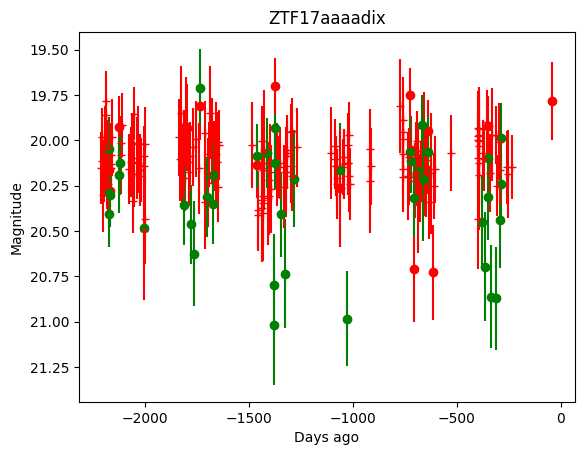

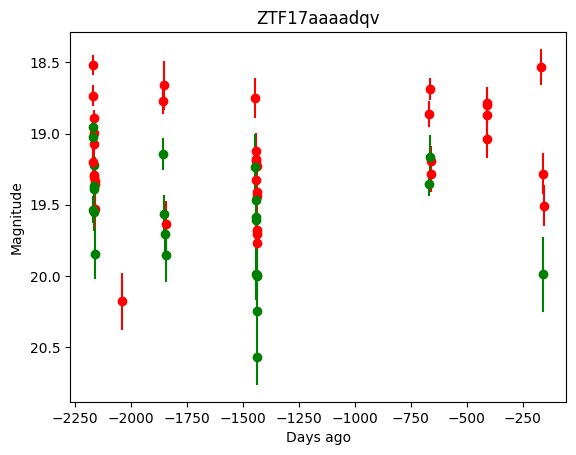

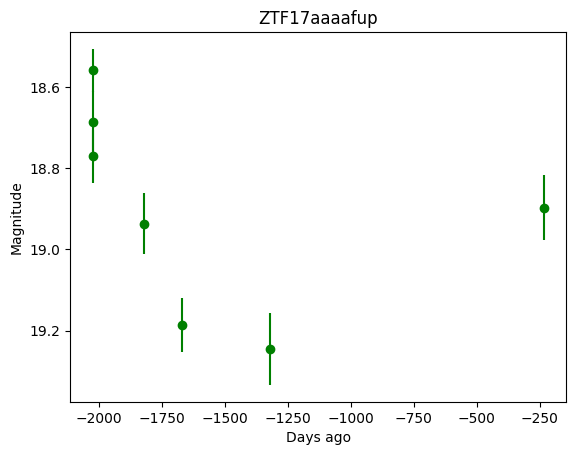

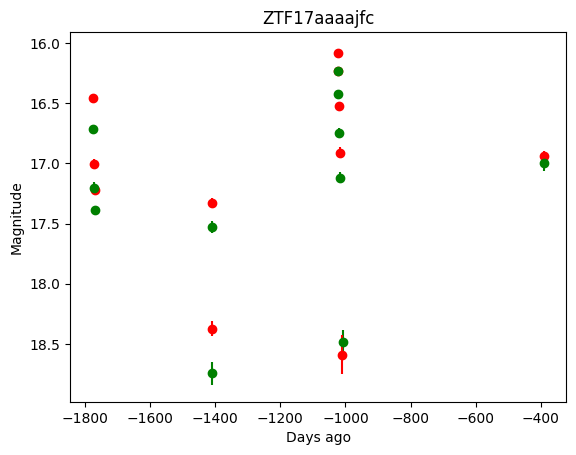

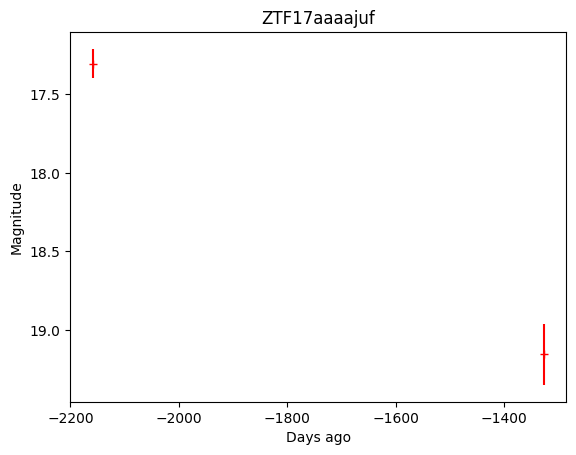

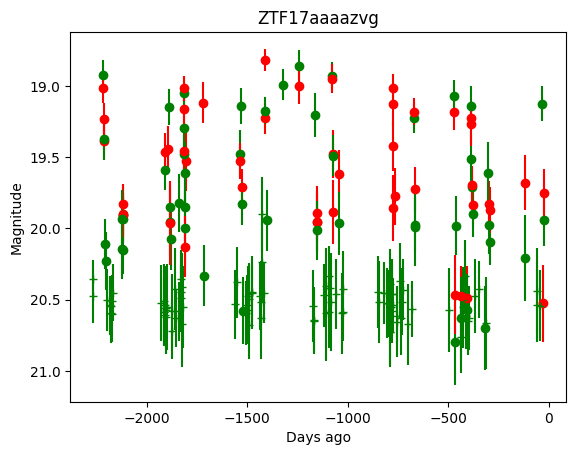

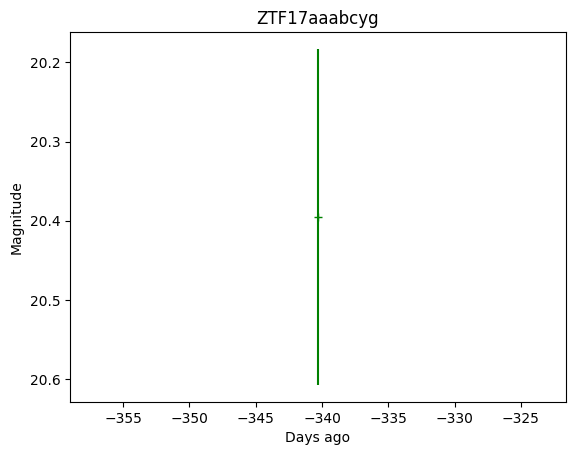

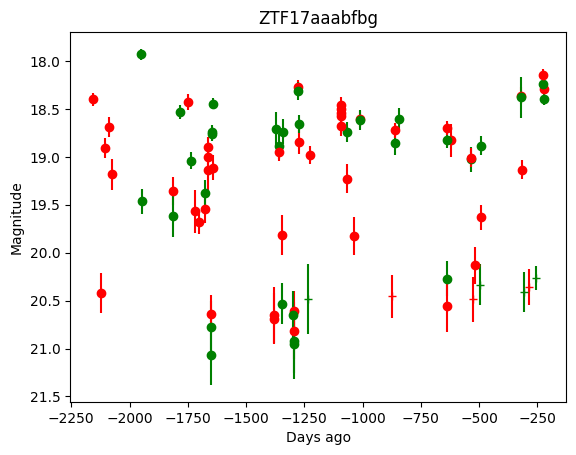

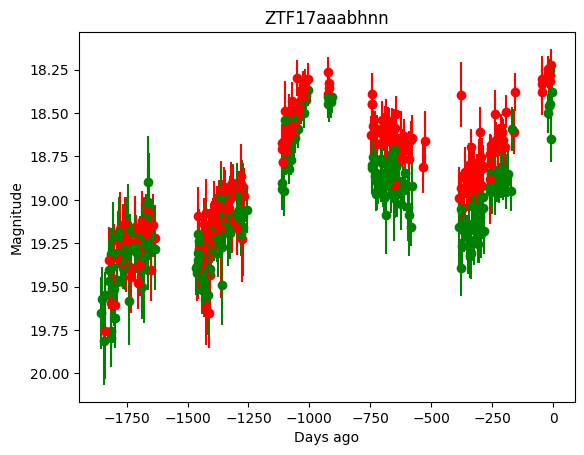

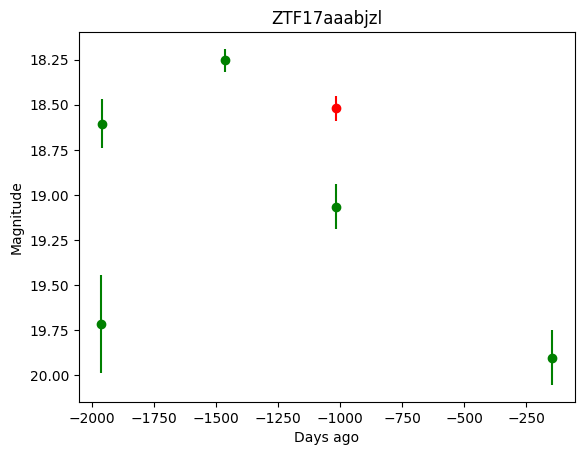

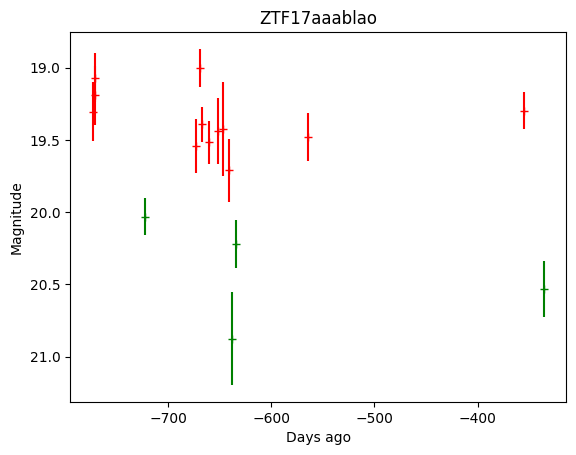

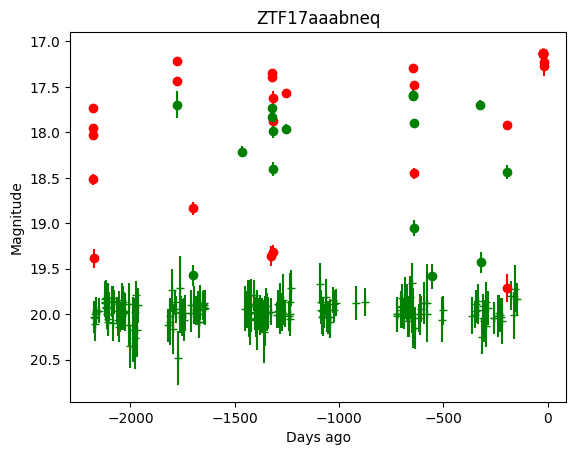

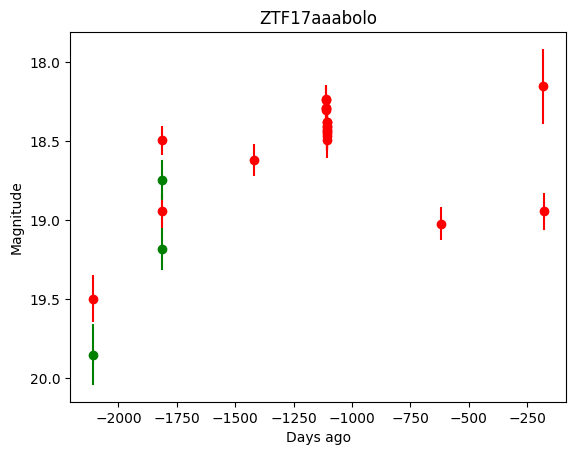

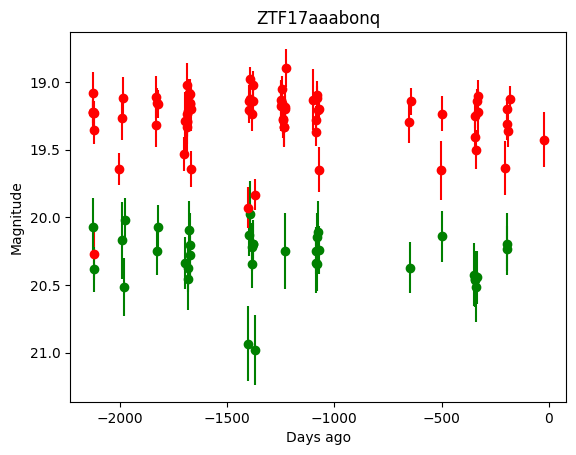

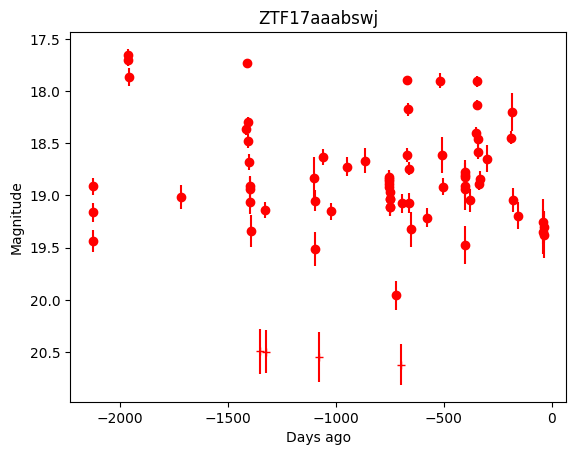

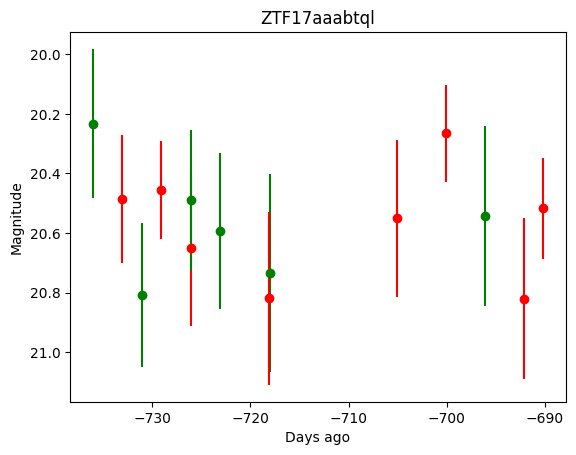

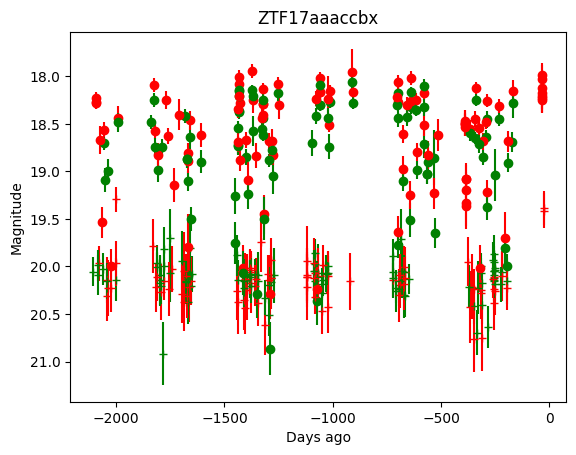

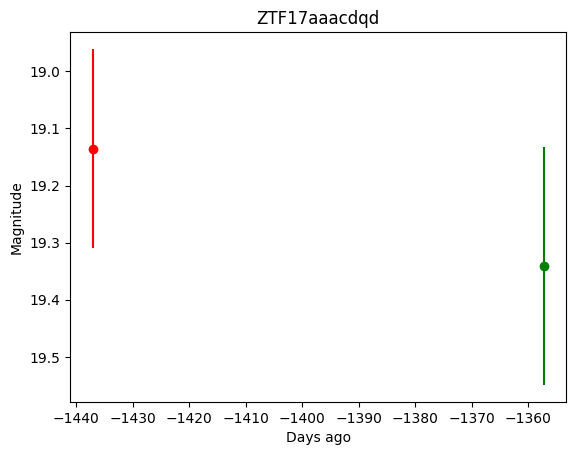

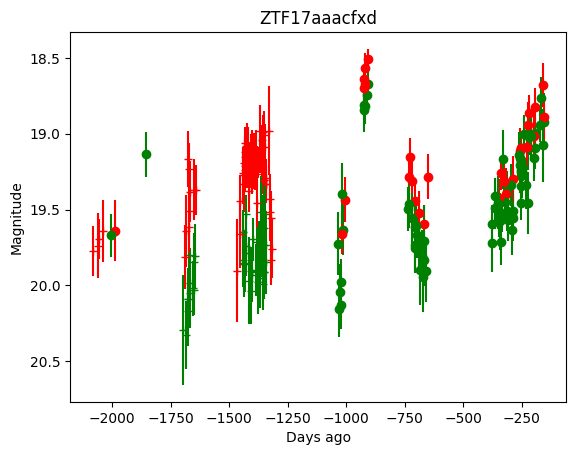

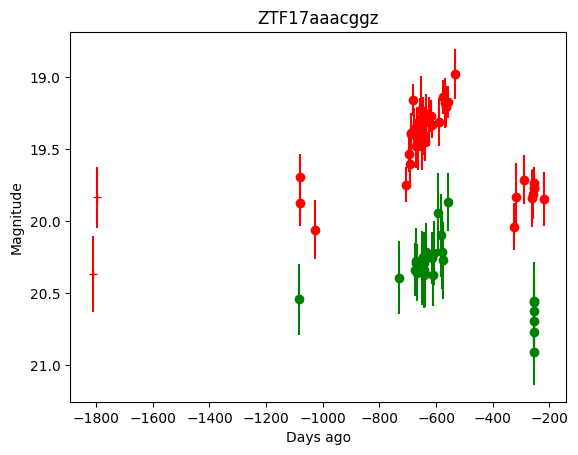

In [30]:
response = L.objects(objectList)

# create an dictionary of lightcurves
lcsDict = {}
for obj in response:
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r',3:'k'}

now = Time.now().jd

for obj in response:
    plt.figure()
    plt.subplot(111)
    for i in lcsDict[obj['objectId']]['candidates']:
        if 'isdiffpos' in i:
            if i['isdiffpos']=='t':
                plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
            else:
                plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='+',color=cols[i['fid']])

    plt.gca().invert_yaxis()
    plt.ylabel('Magnitude')
    plt.xlabel('Days ago')
    plt.title(obj['objectId'])
    plt.show()
